# Exploring and Cleaning MTA Bridge and Tunnel Data


## Introduction

The ideal way to examine how air pollution in NYC changed in response to COVID-19 would include measuring how the burning of hydrocarbon fuels (gasoline, diesel, heating oil, etc.) changed in response to the COVID-related changes in activity.Free, available datasets measuring direct fuel consumption are not available. Measures of vehicle activity must then be used a proxy for measuring pollution from vehicles. 

The Metropolitan Transit Authority's (MTA) daily traffic counts on toll bridges and tunnels is perhaps the best dataset that is:
- available
- free
- up-to-date (has 2020 data)
- sufficiently granular (e.g. data is not quarterly aggregation)

We would like to explore this dataset to make sure it is a reasonable representation of NYC vehicle activity and if appropriate, prepare it for further analysis. 


### Loading modules

In [1]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import folium
import pickle

### Settings

In [2]:
pd.options.display.min_rows =30
pd.options.display.max_rows =40
pd.options.display.width = 120
pd.options.display.float_format = '{:20,.2f}'.format

### Helper Functions

In [3]:
def distribution_stats(series):
    """Return pd.Series of distribution stats for input series"""
    stats = {
        "count": series.count(),
        "min": series.min(),
        "1%": series.quantile(0.01),
        "5%": series.quantile(0.05),
        "25%": series.quantile(0.25),
        "50%": series.quantile(0.50),
        "75%": series.quantile(0.75),
        "95%": series.quantile(0.95),
        "99%": series.quantile(0.99),
        "max": series.max(),
        "median": series.median(),
        "mean": series.mean(),
        "median absolute deviation ": scipy.stats.median_absolute_deviation(series),
        "standard deviation": series.std(),
        "skew": series.skew(),
        "kurtosis": series.kurtosis(),
    }
    stats = pd.DataFrame.from_dict(stats, orient="index", columns=["Stat Value"])
    return stats


def frequency_table(series):
    """Return pd.Series frequency table for input series"""
    freq = series.value_counts()
    freq.name = "Count"
    percent = series.value_counts(normalize=True) * 100
    percent = pd.Series(["{0:.2f}%".format(x) for x in percent], index=percent.index)
    percent.name = "% of total"
    output = pd.concat([freq, percent], axis=1)
    output.index = [abbreviate_string(x, limit=60) for x in output.index]
    return output


def abbreviate_string(s, limit=60):
    if isinstance(s, str):
        return s[:limit]
    else:
        return s

    
def apply_per_period(series, start, end, freq, func=len):
    """Apply  function to datetime-indexed series
    over specified time interval. Start and end can be strings or
    datetime-like objects. Frequency is specified using pandas offset aliases.
    
    Meant to quickly identify gaps in data or perform simple functions over period of time
    """
    series = series.rename(func.__name__)
    df = pd.DataFrame(series)
    df['period'] = df.index.to_period(freq)  # assigns timestamp to corresponding period
    results = df.groupby(['period']).agg(func)
    time_index = pd.period_range(start, end, freq=freq)
    results = results.reindex(time_index)  # reindexing identifies gaps over interval
    return results


### Loading data

Vehicle counts at MTA bridges and tunnels can be found at:
- https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga

or directly downloaded from (an API key may be required):
- https://data.ny.gov/api/views/qzve-kjga/rows.csv?accessType=DOWNLOAD&sorting=true

Pandas will be used to load the data from csv to a Pandas DataFrame(DF)

In [4]:
bridge_tunnel = pd.read_csv(
    "https://data.ny.gov/api/views/qzve-kjga/rows.csv?accessType=DOWNLOAD&sorting=true"
)

**Plaza ID to Location Mapping**\
"Plaza ID Mappiing.csv" was manually created using the MTA Data Dictionary

In [5]:
plaza_id_csv = pd.read_csv(
    "../data/vehicle/bridge and tunnel/Plaza ID Mapping.csv"
)
plaza_bridge_mapping = {
    row["Plaza ID"]: row["Bridge / Tunnel"] for index, row in plaza_id_csv.iterrows()
}
loc_latlong_mapping = {
    row["Bridge / Tunnel"]: (row["Latitude"], row["Longitude"]) for index, row in plaza_id_csv.iterrows()
}

### Exploring Data

**Inspecting data dimensions and data type**

In [6]:
bridge_tunnel.shape

(1591991, 6)

In [7]:
bridge_tunnel.dtypes

Plaza ID                       int64
Date                          object
Hour                           int64
Direction                     object
# Vehicles - ETC (E-ZPass)     int64
# Vehicles - Cash/VToll        int64
dtype: object

**Checking DF for duplicates**

In [8]:
bridge_tunnel.duplicated().sum()

2184

**Removing duplicates**

The 2184 duplicates are removed

In [9]:
bt_clean = bridge_tunnel[bridge_tunnel.duplicated() == False].copy(deep=True)
bt_clean.shape

(1589807, 6)

**Checking for null values**

Pandas does not detect obvious null values

In [10]:
bt_clean.isna().sum()

Plaza ID                      0
Date                          0
Hour                          0
Direction                     0
# Vehicles - ETC (E-ZPass)    0
# Vehicles - Cash/VToll       0
dtype: int64

**Creating Datetime Column**

A datetime column will be useful for current and future analysis

In [11]:
bt_clean["date hour"] = bt_clean["Date"] + " " + bt_clean["Hour"].astype(dtype="str")
bt_clean["Datetime"] = pd.to_datetime(bt_clean["date hour"], format="%m/%d/%Y %H")
bt_clean = bt_clean.drop(["date hour"], axis=1)

**Creating Location Column**

Location and lat-long columns will be useful for current and future analysis

In [12]:
bt_clean["Location"] = bt_clean["Plaza ID"].map(plaza_bridge_mapping)
bt_clean["Lat-Long"] = bt_clean["Location"].map(loc_latlong_mapping)

**Checking Plaza ID**

There data dictionary references 20 distinct Plaza ID values. All 20 are present. Some plazas have more entries than others. 

In [13]:
len(bt_clean["Plaza ID"].unique())  # returns numpy ndarray

20

In [14]:
frequency_table(bt_clean["Plaza ID"])

,Count,% of total
9,135216,8.51%
3,135216,8.51%
1,130560,8.21%
2,130560,8.21%
5,128352,8.07%
6,128352,8.07%
7,123072,7.74%
8,122784,7.72%
4,120624,7.59%
11,65832,4.14%


Comparing locations to plaza IDs, we see that all bridges/tunnels have more than one plaza ID. The Triborough Bridge (RFK Bridge) has four plazas, two each corresponding to plazas entering Manhattan and the Bronx. This helps explain why some values have more entries. 

In [15]:
frequency_table(bt_clean["Location"])
pd.crosstab(bt_clean["Plaza ID"], bt_clean["Location"])

Location,Bronx-Whitestone Bridge (BWB),Cross Bay Veterans Memorial Bridge (CBB),Henry Hudson Bridge (HHB),Hugh L. Carey Tunnel (HCT),Marine Parkway-Gil Hodges Memorial Bridge (MPB),Queens Midtown Tunnel (QMT),Robert F. Kennedy Bridge,Throgs Neck Bridge (TNB),Verrazano-Narrows Bridge (VNB)
Plaza ID,,,,,,,,,
1,0,0,0,0,0,0,130560,0,0
2,0,0,0,0,0,0,130560,0,0
3,135216,0,0,0,0,0,0,0,0
4,0,0,120624,0,0,0,0,0,0
5,0,0,0,0,128352,0,0,0,0
6,0,128352,0,0,0,0,0,0,0
7,0,0,0,0,0,123072,0,0,0
8,0,0,0,122784,0,0,0,0,0
9,0,0,0,0,0,0,0,135216,0


Inspecting the least common plaza, plaza 22, we see it only has outbound (Direction = O) but not inbound traffic further explaining the inbalance in entries among the plazas.

In [16]:
bt_clean[bt_clean["Plaza ID"] == 22].iloc[:10]

,Plaza ID,Date,Hour,Direction,# Vehicles - ETC (E-ZPass),# Vehicles - Cash/VToll,Datetime,Location,Lat-Long
24,22,05/02/2020,0,O,259,63,2020-05-02 00:00:00,Robert F. Kennedy Bridge,"(40.779648, -73.926771)"
25,22,05/02/2020,1,O,122,40,2020-05-02 01:00:00,Robert F. Kennedy Bridge,"(40.779648, -73.926771)"
26,22,05/02/2020,2,O,83,34,2020-05-02 02:00:00,Robert F. Kennedy Bridge,"(40.779648, -73.926771)"
27,22,05/02/2020,3,O,71,25,2020-05-02 03:00:00,Robert F. Kennedy Bridge,"(40.779648, -73.926771)"
28,22,05/02/2020,4,O,106,27,2020-05-02 04:00:00,Robert F. Kennedy Bridge,"(40.779648, -73.926771)"
29,22,05/02/2020,5,O,161,32,2020-05-02 05:00:00,Robert F. Kennedy Bridge,"(40.779648, -73.926771)"
30,22,05/02/2020,6,O,261,41,2020-05-02 06:00:00,Robert F. Kennedy Bridge,"(40.779648, -73.926771)"
31,22,05/02/2020,7,O,403,62,2020-05-02 07:00:00,Robert F. Kennedy Bridge,"(40.779648, -73.926771)"
32,22,05/02/2020,8,O,497,76,2020-05-02 08:00:00,Robert F. Kennedy Bridge,"(40.779648, -73.926771)"
33,22,05/02/2020,9,O,564,104,2020-05-02 09:00:00,Robert F. Kennedy Bridge,"(40.779648, -73.926771)"


Comparing the date range for the plaza with the most entries (plaza 9) to the plaza (plaza 22) with the fewest entries, we see that plaza 9 has a longer history, explaining the discrepancy

In [17]:
bt_clean['Datetime'][bt_clean["Plaza ID"] == 22].max() - bt_clean['Datetime'][bt_clean["Plaza ID"] == 22].min()

Timedelta('972 days 23:00:00')

In [18]:
bt_clean['Datetime'][bt_clean["Plaza ID"] == 9].max() - bt_clean['Datetime'][bt_clean["Plaza ID"] == 9].min()

Timedelta('2822 days 23:00:00')

**E-ZPass and Cash/Toll Vehicle Counts**

We combine them to get total vehicles that crossed a toll bridge/tunnel plaza at a given hour. Then we check to make sure the distribution of values is reasonable. The maximum value of vehicles passing a plaza in a one hour window is 18,834 on a Sunday evening in May on the Verrazano Bridge which is not outlandish to anyone who has driven over the bridge on a weekend. The bridge can carry 6-8 lanes of traffic in one direction depending on the configuration of the HOV lane and is the only road or bridge connecting Staten Island to the rest of NYC.

In [19]:
bt_clean["Total Vehicles"] = (
    bt_clean["# Vehicles - ETC (E-ZPass)"] + bt_clean["# Vehicles - Cash/VToll"]
)

In [20]:
distribution_stats(bt_clean["Total Vehicles"])

,Stat Value
count,"1,589,807.00"
min,0.00
1%,33.00
5%,86.00
25%,501.00
50%,"1,262.00"
75%,"2,498.00"
95%,"4,191.00"
99%,"7,175.00"
max,"18,834.00"


In [21]:
pd.options.display.float_format = '{:20,.2f}'.format

In [22]:
bt_clean[bt_clean["Total Vehicles"] == 18834]

,Plaza ID,Date,Hour,Direction,# Vehicles - ETC (E-ZPass),# Vehicles - Cash/VToll,Datetime,Location,Lat-Long,Total Vehicles
291399,30,05/06/2018,18,O,16854,1980,2018-05-06 18:00:00,Verrazano-Narrows Bridge (VNB),"(40.606460999999996, -74.045057)",18834


**Completeness of Data**

We can verify the data is reasonably complete by making sure most plazas have 24 records per day for each direction. 

In [23]:
hours = bt_clean.groupby(["Date", "Plaza ID", "Direction"]).count()
frequency_table(hours["Hour"])

,Count,% of total
24,66026,99.65%
23,117,0.18%
22,49,0.07%
21,45,0.07%
20,16,0.02%
19,5,0.01%
18,3,0.00%


We can examine to what extent our time period of interest is missing data. We can identify days that are missing data by looking for days with less than 216 (9 locations x 24 hours) observations. **There are 4 days that are completely missing observations but luckily they are not in the window we will focus on.** There other gaps are relatively minor and should not significantly affect the analysis. We shouldn't automatically fill in or smooth these gaps since it is possible that the missing observations could be explained by bridge/tunnel closures leading to gaps in the data. 

In [24]:
hourly_traffic = bt_clean.groupby(by=["Location", "Datetime"], as_index=False)["Total Vehicles"].sum()
hourly_traffic.index = hourly_traffic['Datetime']
daily_counts = apply_per_period(hourly_traffic["Location"], start="02/01/2019", end="05/01/2020", freq='D', func=len)
daily_counts = daily_counts.fillna(0)  # apply_per_period returns NaN for gaps in data
dates_missing = daily_counts[daily_counts["len"] < 216]
dates_missing

,len
2019-02-05,215.00
2019-02-06,215.00
2019-02-26,215.00
2019-03-01,215.00
2019-03-10,207.00
2019-04-23,215.00
2019-04-24,215.00
2019-04-26,215.00
2019-04-27,213.00
2019-06-14,0.00


### To What Extent Does Data Represent NYC Traffic Levels?

The traffic on these MTA toll bridges and tunnels should reasonably reflect NYC vehicle activity. The bridges are tunnels are distributed through the city and do not exclusively focus on access to a central business district. All five boroughs (counties) are connected through these bridges/tunnels. 

In [25]:
map_center = (40.69, -73.92)
locations = bt_clean["Lat-Long"].unique()
map_nyc = folium.Map(
    location=map_center, zoom_start=10, tiles="cartodbpositron", width=800, height=600
)
for loc in locations:
    folium.Marker(loc).add_to(map_nyc) 
map_nyc

Cumulative traffic levels drop during the weekends, but not dramatically suggesting that the data does not over-index on rush-hour commuters.  

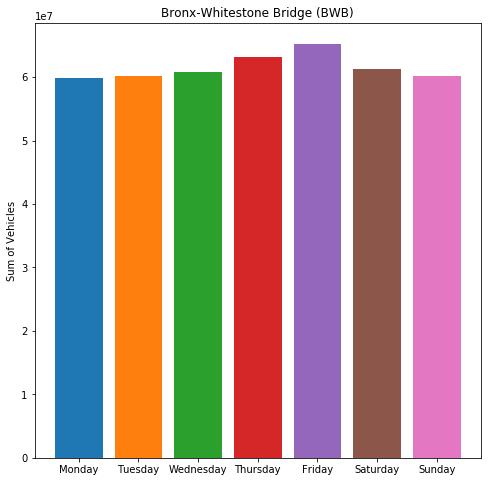

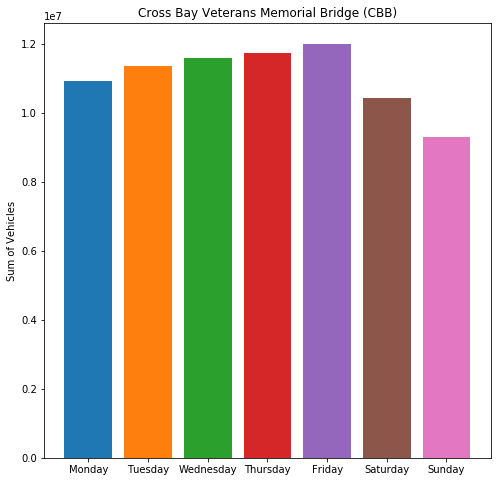

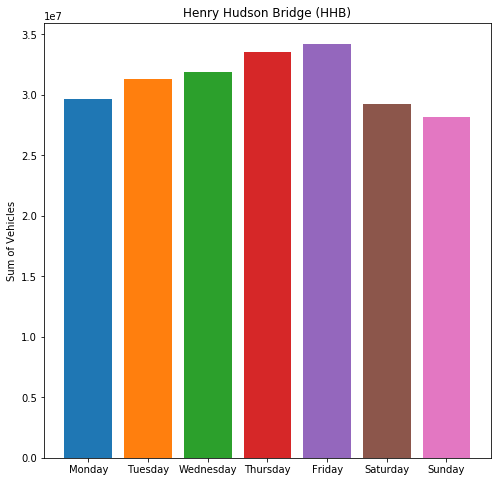

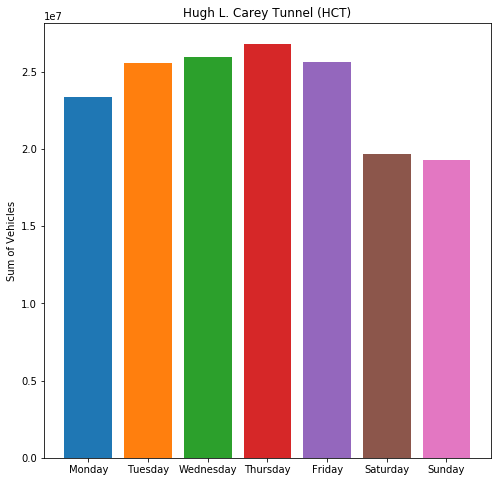

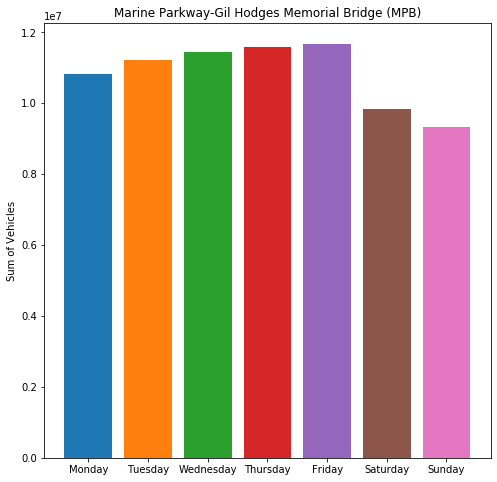

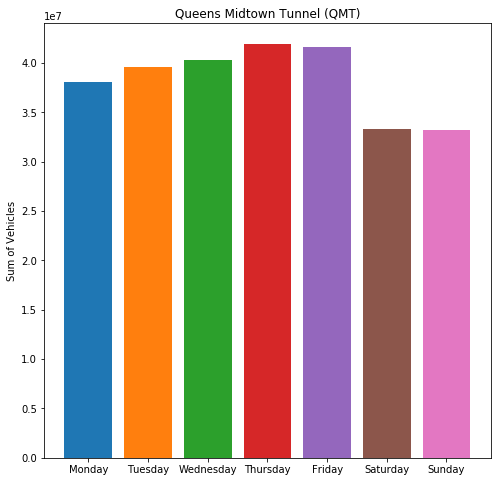

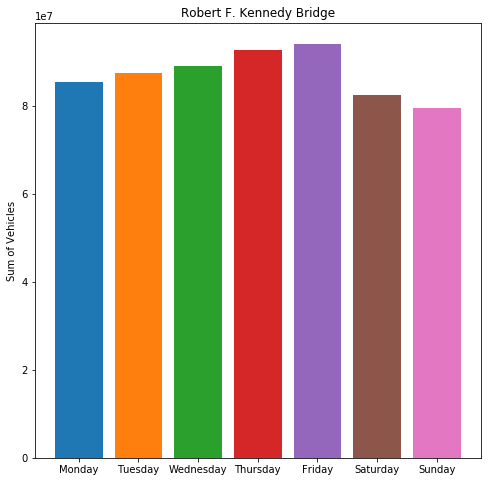

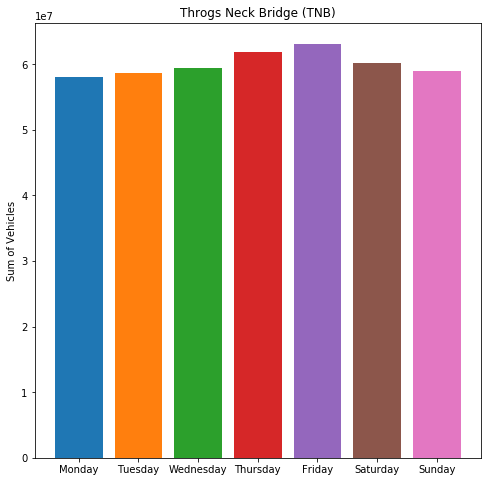

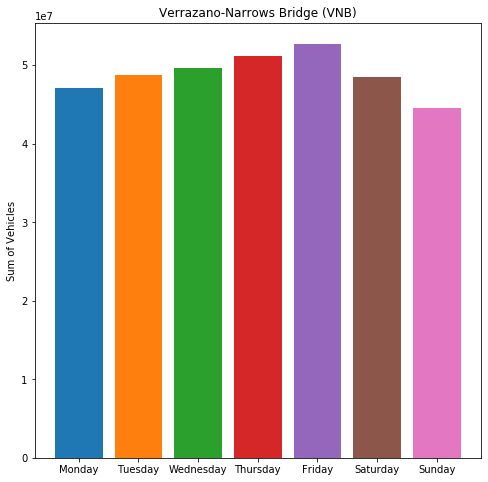

In [26]:
week = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}
for toll in hourly_traffic['Location'].unique():
    location = hourly_traffic[hourly_traffic['Location'] == toll]
    y = location.groupby(by=location["Datetime"].dt.dayofweek, as_index=False)[
        "Total Vehicles"
    ].sum()
    y.index = y.index.map(week)

    # make plot
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_ylabel('Sum of Vehicles')
    ax.set_title(toll)
    for i in range(len(y)):
        ax.bar(y.index[i], height=y['Total Vehicles'].iloc[i], align='center' )
    plt.show()

Traffic levels reflect typical daily traffic patterns with an evening peak and early morning lull indicating that the dataset does not over-index on high traffic locations that are excessively busy throughout the day. 

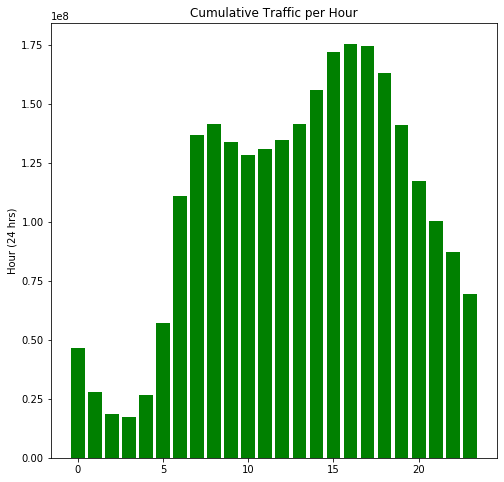

In [27]:
y = hourly_traffic.groupby(by=hourly_traffic["Datetime"].dt.hour, as_index=True).sum()

# make plot
fig, ax = plt.subplots(figsize=(8,8))
ax.set_ylabel('Sum of Vehicles')
ax.set_ylabel('Hour (24 hrs)')
ax.set_title("Cumulative Traffic per Hour")
for i in range(len(y)):
    ax.bar(y.index[i], height=y['Total Vehicles'].iloc[i], align='center', color='green')
plt.show()

**So far, the dataset seems like an appropriate proxy for overall NYC traffic levels, so lets create an hourly measure of all NYC traffic.** We should verify that the data is well-behaved during our period of analysis. 

In [28]:
traffic_level = hourly_traffic.groupby(by=hourly_traffic['Datetime']).sum()

**The data seems well behaved in the periods we are focusing on.**

Traffic gradually ramps up in the Spring of 2019 as would be expected

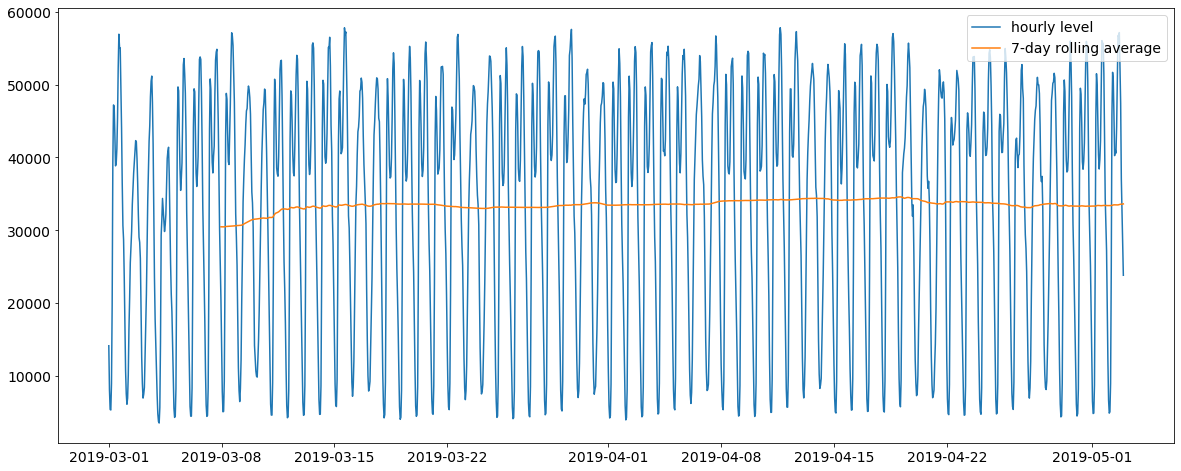

,Total Vehicles
count,"1,511.00"
mean,"33,320.48"
std,"16,332.63"
min,"3,528.00"
25%,"19,096.00"
50%,"38,409.00"
75%,"47,326.00"
max,"57,817.00"


In [29]:
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)
sample = traffic_level[(traffic_level.index > "02/28/2019 23") & (traffic_level.index < "5/3/2019 00")] 
rolling_mean = sample['Total Vehicles'].rolling(window=168).mean()  # 168 = 24 hrs x 7 days
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(sample, label="hourly level")
plt.plot(rolling_mean, label="7-day rolling average")
ax.legend(loc="upper right", fontsize=14)
plt.show()
sample.describe()

Also as expected, NYC traffic drops significantly starting in early March 2020 which corresponds to widespread aggressive measures to combat COVID-19. 

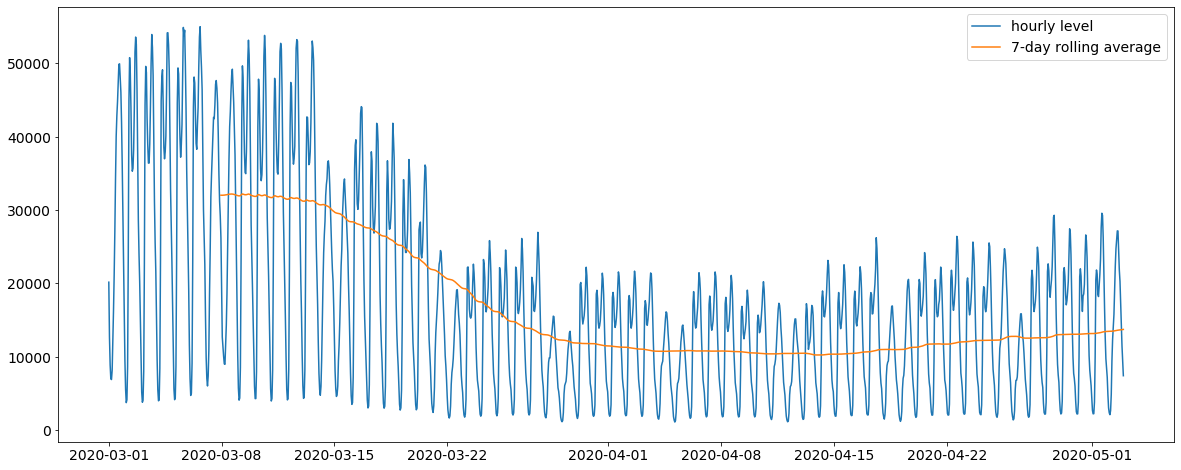

,Total Vehicles
count,"1,511.00"
mean,"17,064.91"
std,"12,958.69"
min,"1,123.00"
25%,"6,561.00"
50%,"15,058.00"
75%,"22,258.50"
max,"54,994.00"


In [30]:
sample = traffic_level[ (traffic_level.index > "02/29/2020 23") & (traffic_level.index < "5/3/2020 00") ] 
rolling_mean = sample['Total Vehicles'].rolling(window=168).mean()  # 168 = 24 hrs x 7 days
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(sample, label="hourly level")
plt.plot(rolling_mean, label="7-day rolling average")
ax.legend(loc="upper right", fontsize=14)
plt.show()
sample.describe()

In [31]:
with open("../data/vehicle/clean_mta_data", 'wb+') as output_fh:
    pickle.dump(traffic_level, output_fh)

## Conclusion

**The MTA Bridge and Tunnel Toll data appears to be a useful proxy for overall NYC traffic levels.**
- It is a large hourly sample from connectors between all five boroughs
- The toll locations are spread throughout the city and do not over-index on a central business district
- The weekly and daily periodicity is inline with typical traffic patterns further reinforcing the idea that the data is a useful proxy for citywide traffic levels
- 2020 data display traffic patterns consistent reported drops in traffic due to COVID-19
